# Shaat Geochron

In [1]:
import numpy as np
import pandas as pd

import radage

import matplotlib.pyplot as plt

## Load Data

In [2]:
z_sams = ['SD39', 'SD50', 'SD52']

In [3]:
z_df = pd.read_excel('../data/zircon_U-Pb/LASS ICPMS U-Pb.xlsx')

### Process Zircon Data

Use the `radage` package to generate `UPb` objects for interacting with the isotopic data.

In [4]:
radages = []
for ii, row in z_df.iterrows():
    radages.append(radage.UPb(
        row['Final Pb206/U238_mean'],
        row['Final Pb206/U238_2SE(prop)']/2,
        row['Final Pb207/U235_mean'],
        row['Final Pb207/U235_2SE(prop)']/2,
        row['Final Pb207/Pb206_mean'],
        row['Final Pb207/Pb206_2SE(prop)']/2,
        row['rho 206Pb/238U v 207Pb/235U'],
        row['rho 207Pb/206Pb v 238U/206Pb'],
        )
    )

# save radage.UPb objects for each analysis
z_df['radage'] = radages

# also save relative age discordance for each analysis
z_df['discordance'] = [age.discordance() for ii, age in z_df['radage'].items()]

In [5]:
# concordant at some threshold
thres = 0.015
z_df['concordant'] = z_df['discordance'] < thres

In [6]:
# sample dataframe, zircons
z_samp_df = pd.DataFrame(index=z_sams, columns=['mean', 'sig', 'mswd', 'ages', 'ages 2s', 'concordant radages', 'discordant radages'])

for ii, z_sam in enumerate(z_sams):
    idx_sam = z_df['Sample'] == z_sam
    cur_df = z_df.loc[idx_sam]
    # concordant analyses
    idx_conc = cur_df['concordant'] == True
    z_samp_df.loc[z_sam, 'concordant radages'] = cur_df[idx_conc]['radage'].values
    z_samp_df.loc[z_sam, 'discordant radages'] = cur_df[~idx_conc]['radage'].values
    
    # concordant ages with uncertainty as 2d array
    ages_conc = np.array([zirc.date68() for zirc in cur_df[idx_conc]['radage'].values])
    z_samp_df.loc[z_sam, 'ages'] = ages_conc[:, 0]
    z_samp_df.loc[z_sam, 'ages 2s'] = 2*ages_conc[:, 1]
    
    # weighted mean
    cur_mean, cur_sig, cur_mswd = radage.weighted_mean(ages_conc[:,0], ages_conc[:, 1], 
                                                       sig_method='unbiased')
    z_samp_df.loc[z_sam, 'mean'] = cur_mean
    z_samp_df.loc[z_sam, 'sig'] = cur_sig
    z_samp_df.loc[z_sam, 'mswd'] = cur_mswd

In [7]:
# sample styling
z_samp_styles = {'SD39': {'facecolor': 'cornflowerblue', 'edgecolor': 'k'},
                 'SD50': {'facecolor': 'slateblue', 'edgecolor': 'k'},
                 'SD52': {'facecolor': 'steelblue', 'edgecolor': 'k'}}

## Zircon Concordia and Weighted Means

In [8]:
style_conc = {'facecolor': 'forestgreen', 
              'linewidth': 0.5,
              'edgecolor': 'k',
              'alpha': 0.6}
style_disc = {'facecolor': 'salmon', 
              'linewidth': 0.5,
              'edgecolor': 'k',
              'linestyle': '--',
              'alpha': 0.3}

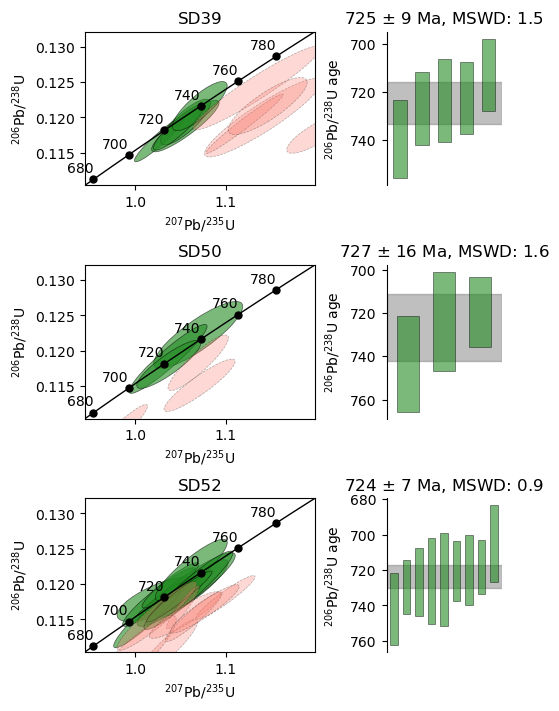

In [9]:
fig, ax = plt.subplots(len(z_sams), 2, figsize=(5, 7), layout='constrained', width_ratios=[2, 1])

for ii, z_sam in enumerate(z_sams):
    
    # concordia
    # concordant
    radage.plotting.plot_ages_concordia(z_samp_df.loc[z_sam, 'concordant radages'],
                                        ax=ax[ii, 0], 
                                        patch_dict=style_conc, 
                                        t1=675, t2=800)
    
    # discordant
    radage.plotting.plot_ellipses_68_75(z_samp_df.loc[z_sam, 'discordant radages'], ax=ax[ii, 0], patch_dict=style_disc)
    
    ax[ii, 0].set_title(z_sam)
        
    # weighted means
    radage.plotting.age_rank_plot(z_samp_df.loc[z_sam, 'ages'], 
                         z_samp_df.loc[z_sam, 'ages 2s'], 
                         ax=ax[ii, 1], patch_dict=style_conc)
    cur_mean = z_samp_df.loc[z_sam, 'mean']
    cur_sig = z_samp_df.loc[z_sam, 'sig']
    cur_mswd = z_samp_df.loc[z_sam, 'mswd']
    ax[ii, 1].axhspan(cur_mean-2*cur_sig,cur_mean+2*cur_sig, color='grey', alpha=0.5, zorder=0)
    ax[ii, 1].set_title(f'{cur_mean:1.0f} $\\pm$ {2*cur_sig:1.0f} Ma, MSWD: {cur_mswd:1.1f}')       
    ax[ii, 1].set_ylabel('$^{206}$Pb/$^{238}$U age')

plt.savefig('output/zircon_concordia_age-rank.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.savefig('output/zircon_concordia_age-rank.png', format='png', dpi=600, bbox_inches='tight')

## Zircon Weighted Means by Sample

In [10]:
z_samp_dict = z_samp_df.to_dict(orient='index')
for sam in z_sams:
    z_samp_dict[sam]['style'] = z_samp_styles[sam]

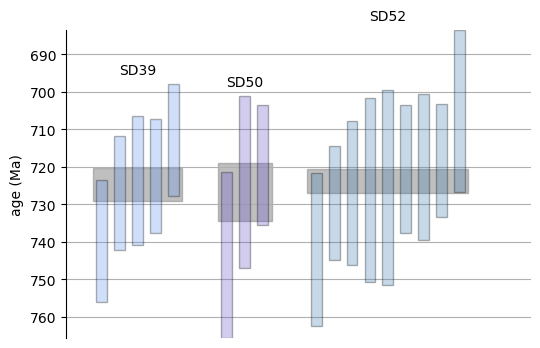

In [11]:
fig = plt.figure(figsize=(6,4))
ax = plt.axes()

radage.plotting.age_rank_plot_samples(z_samp_dict, ax=ax, sample_spacing=2)

ax.set_axisbelow(True)
ax.grid('yaxis')
ax.set_ylabel('age (Ma)')

plt.savefig('output/zircon_age-rank.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.savefig('output/zircon_age-rank.png', format='png', dpi=600, bbox_inches='tight')

plt.show()

## Zircon Combined Weighted Mean

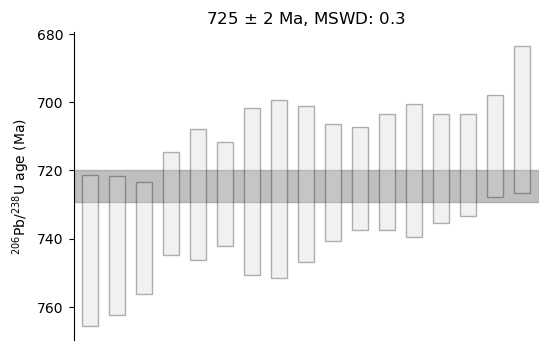

In [12]:
cur_mean, cur_sig, cur_mswd = radage.weighted_mean(np.concatenate(z_samp_df['ages'].values),
                                                   np.concatenate(z_samp_df['ages 2s'].values),
                                                   sig_method='unbiased')

fig = plt.figure(figsize=(6, 4))
ax = plt.axes()

radage.plotting.age_rank_plot(np.concatenate(z_samp_df['ages'].values), 
                     np.concatenate(z_samp_df['ages 2s'].values),
                     ax=ax)
ax.axhspan(cur_mean-2*cur_sig, cur_mean+2*cur_sig, color='grey', alpha=0.5, zorder=0)
ax.set_title(f'{cur_mean:1.0f} $\\pm$ {cur_sig:1.0f} Ma, MSWD: {cur_mswd:1.1f}')
ax.set_ylabel('$^{206}$Pb/$^{238}$U age (Ma)')

plt.savefig('output/zircon_combined_age-rank.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.savefig('output/zircon_combined_age-rank.png', format='png', dpi=600, bbox_inches='tight')

plt.show()